## Another CNN architecture test

In [50]:
%config InlineBackend.figure_format = 'retina'

import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch import nn
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [51]:
data_dir = "../400_4_classes"

In [52]:
def load_split_train_test(datadir, valid_size=0.2):
    train_transforms = transforms.Compose(
        [transforms.Resize(224), transforms.ToTensor()]
    )
    test_transforms = transforms.Compose(
        [transforms.Resize(224), transforms.ToTensor()]
    )

    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)

    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    train_loader = DataLoader(train_data, sampler=train_sampler, batch_size=80)
    test_loader = DataLoader(test_data, sampler=test_sampler, batch_size=80)
    return train_loader, test_loader

train_loader, test_loader = load_split_train_test(data_dir, 0.2)
print(train_loader.dataset.classes)

['glass', 'metal', 'paper', 'plastic']


In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [54]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(64 * 28 * 37, 512)
        self.fc2 = nn.Linear(512, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.reshape(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [55]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [56]:
num_epochs = 35
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 4 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

torch.save(model, "mod.pth")

Epoch [1/35], Step [4/16], Loss: 1.5492, Accuracy: 21.25%
Epoch [1/35], Step [8/16], Loss: 1.3645, Accuracy: 26.25%
Epoch [1/35], Step [12/16], Loss: 1.3382, Accuracy: 37.50%
Epoch [1/35], Step [16/16], Loss: 1.3840, Accuracy: 27.50%
Epoch [2/35], Step [4/16], Loss: 1.3236, Accuracy: 37.50%
Epoch [2/35], Step [8/16], Loss: 1.3166, Accuracy: 36.25%
Epoch [2/35], Step [12/16], Loss: 1.2513, Accuracy: 38.75%
Epoch [2/35], Step [16/16], Loss: 1.3110, Accuracy: 43.75%
Epoch [3/35], Step [4/16], Loss: 1.1886, Accuracy: 42.50%
Epoch [3/35], Step [8/16], Loss: 1.0923, Accuracy: 52.50%
Epoch [3/35], Step [12/16], Loss: 1.1095, Accuracy: 50.00%
Epoch [3/35], Step [16/16], Loss: 1.2407, Accuracy: 38.75%
Epoch [4/35], Step [4/16], Loss: 1.0958, Accuracy: 56.25%
Epoch [4/35], Step [8/16], Loss: 1.2120, Accuracy: 46.25%
Epoch [4/35], Step [12/16], Loss: 1.0123, Accuracy: 55.00%
Epoch [4/35], Step [16/16], Loss: 1.1713, Accuracy: 40.00%
Epoch [5/35], Step [4/16], Loss: 1.0300, Accuracy: 57.50%
Epoch 

In [57]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

Test Accuracy of the model on the 10000 test images: 62.5 %


In [58]:
data_dir = "mod.pth"

test_transforms = transforms.Compose([transforms.Resize(224), transforms.ToTensor()])

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load("mod.pth")

In [60]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [61]:
def get_random_images(num):
    data_dir = "../400_4_classes_test"
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler

    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

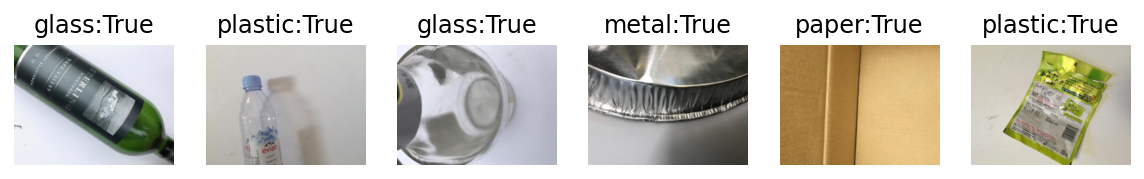

In [62]:
classes = ["glass", "metal", "paper", "plastic"]
to_pil = transforms.ToPILImage()
images, labels = get_random_images(6)
fig = plt.figure(figsize=(10, 10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii + 1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis("off")
    plt.imshow(image)
plt.show()